## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX on NVIDIA GPU with:

In [ ]:
%pip install -U "jax[cuda]"

Then, install `evosax` from PyPi:

In [ ]:
%pip install -U "evosax[examples]"

## Import

In [15]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from evosax.algorithms import DiffusionEvolution as ES
from evosax.algorithms.population_based.diffusion_evolution import (
    fitness_mapping_energy,
)
from evosax.problems import BBOBProblem as Problem

In [16]:
seed = 0
key = jax.random.key(seed)

## BBOB Problem

In [3]:
fn_name = "sphere"
num_dims = 2

problem = Problem(
    fn_name=fn_name,
    num_dims=num_dims,
    f_opt=0.0,
    seed=seed,
)

problem_state = problem.init(key)

key, subkey = jax.random.split(key)
solution = problem.sample(subkey)

In [4]:
num_generations = 64
population_size = 1024

es = ES(
    population_size=population_size,
    solution=solution,
    num_generations=num_generations,
)

params = es.default_params
params = params.replace(std_m=1.0)

# Initialize population
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, population_size)
population = jax.vmap(problem.sample)(keys)

key, subkey = jax.random.split(key)
fitness, problem_state, _ = problem.eval(subkey, population, problem_state)

key, subkey = jax.random.split(key)
state = es.init(subkey, population, fitness, params)

### Run

In [5]:
def step(carry, key):
    state, params, problem_state = carry
    key_ask, key_eval, key_tell = jax.random.split(key, 3)

    population, state = es.ask(key_ask, state, params)

    population = jnp.clip(population, -5, 5)
    fitness, problem_state, _ = problem.eval(key_eval, population, problem_state)

    state, metrics = es.tell(key_tell, population, fitness, state, params)

    return (state, params, problem_state), (state, metrics)

In [6]:
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_generations)
_, (states, metrics) = jax.lax.scan(
    step,
    (state, params, problem_state),
    keys,
)

""

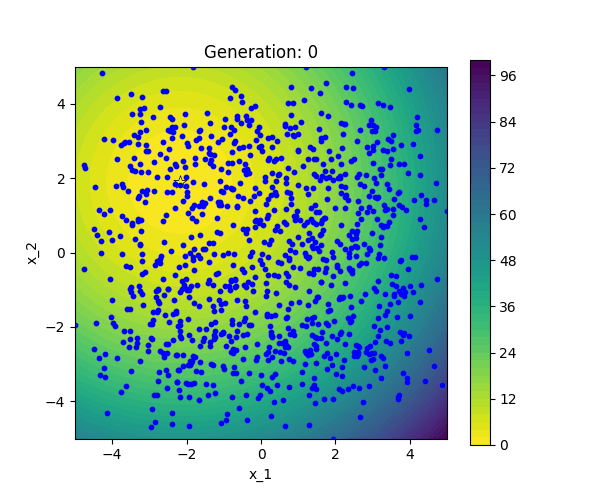

In [37]:
import matplotlib.animation as animation
import mediapy
from matplotlib.animation import PillowWriter

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Visualize the problem landscape
key, subkey = jax.random.split(key)
problem.visualize_2d(subkey, ax=ax)

# Extract population trajectory from states
populations = states.population  # Shape: (num_generations, population_size, num_dims)

# Create a scatter plot for the population
scatter = ax.scatter([], [], color="blue", s=10)

# Add a title with generation counter
title = ax.set_title("Generation: 0")


def init():
    scatter.set_offsets(jnp.empty((0, 2)))
    return scatter, title


def update(frame):
    # Update the positions of the population
    # populations[frame] has shape (population_size, num_dims)
    scatter.set_offsets(populations[frame])

    # Update the title with current generation
    title.set_text(f"Generation: {frame}")

    return scatter, title


# Create the animation
anim = animation.FuncAnimation(
    fig, update, frames=len(populations), init_func=init, blit=True
)

plt.close()

# Create a writer
path = "diffusion_evolution.gif"
anim.save(path, writer=PillowWriter())

# Display the GIF in the notebook
mediapy.show_video(mediapy.read_video(path), fps=10, codec="gif")

## Two Peak Problem

In [26]:
from functools import partial


class TwoPeakProblem:
    """Two peak problem."""

    def __init__(self, fn_name="density", num_dims=2):
        """Initialize two peak problem."""
        self.fn_name = fn_name
        self.num_dims = num_dims

        # Set bounds
        self.bounds = jnp.array([[-5.0, 5.0]] * num_dims)

        # Set peaks
        self.mu1 = jnp.array([-1.0, -1.0])
        self.mu2 = jnp.array([1.0, 1.0])
        self.std = 0.1 if fn_name == "density" else 0.5

        # Set one of the optima as x_opt
        self.x_opt = self.mu1  # Could also use self.mu2 since both are optimal

    @partial(jax.jit, static_argnames=("self",))
    def eval(self, key, x):
        """Evaluate solution."""
        if self.fn_name == "density":
            # Compute distances to peaks
            d1 = jnp.sum((x - self.mu1[None]) ** 2, axis=-1) / (2 * self.std**2)
            d2 = jnp.sum((x - self.mu2[None]) ** 2, axis=-1) / (2 * self.std**2)

            # Compute densities
            p1 = jnp.exp(-d1)
            p2 = jnp.exp(-d2)

            # Normalize
            max_prob = 2.0  # Since each peak has max density of 1
            density = (p1 + p2) / max_prob * 2

            return -density  # Negate since we minimize

        else:  # step function
            # Compute minimal distance to peaks
            d1 = jnp.linalg.norm(x - self.mu1[None], axis=-1)
            d2 = jnp.linalg.norm(x - self.mu2[None], axis=-1)
            d = jnp.minimum(d1, d2)

            # Step function
            p = (d < self.std).astype(float)
            p = jnp.clip(p, 1e-9, 1)

            return -p  # Negate since we minimize

    @partial(jax.jit, static_argnames=("self",))
    def sample(self, key):
        """Sample random solution."""
        return jax.random.uniform(
            key,
            shape=(self.num_dims,),
            minval=self.bounds[:, 0],
            maxval=self.bounds[:, 1],
        )


problem = TwoPeakProblem()

key, subkey = jax.random.split(key)
solution = problem.sample(subkey)

In [63]:
num_generations = 64
population_size = 512

es = ES(
    population_size=population_size,
    solution=solution,
    num_generations=num_generations,
    fitness_mapping=partial(fitness_mapping_energy, temperature=0.05),
)

params = es.default_params
params = params.replace(std_m=0.5)

# Initialize population
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, population_size)
population = jax.vmap(problem.sample)(keys)

key, subkey = jax.random.split(key)
fitness = problem.eval(subkey, population)

key, subkey = jax.random.split(key)
state = es.init(subkey, population, fitness, params)

### Run

In [64]:
def step(carry, key):
    state, params = carry
    key_ask, key_eval, key_tell = jax.random.split(key, 3)

    population, state = es.ask(key_ask, state, params)

    fitness = problem.eval(key_eval, population)

    state, metrics = es.tell(key_tell, population, fitness, state, params)

    return (state, params), (state, metrics)

In [65]:
key, subkey = jax.random.split(key)
keys = jax.random.split(subkey, num_generations)
_, (states, metrics) = jax.lax.scan(
    step,
    (state, params),
    keys,
)

""

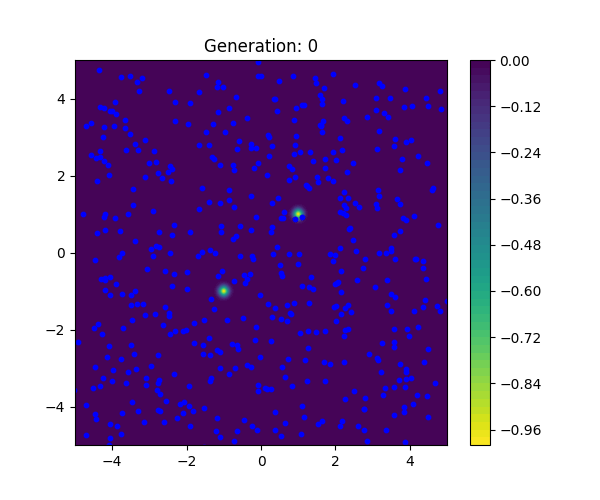

In [66]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import mediapy
from matplotlib.animation import PillowWriter

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Visualize the TwoPeak problem landscape
# Create a meshgrid for visualization
x = jnp.linspace(-5, 5, 1024)
y = jnp.linspace(-5, 5, 1024)
X, Y = jnp.meshgrid(x, y)

# Convert to JAX arrays and reshape for evaluation
grid = jnp.reshape(jnp.stack([X, Y], axis=-1), (-1, 2))

# Evaluate the function at each point
keys = jax.random.split(key, grid.shape[0])
values = jax.vmap(problem.eval, in_axes=(0, 0))(keys, grid)
Z = values.reshape(X.shape)

# Plot the contour
contour = ax.contourf(X, Y, Z, cmap="viridis_r", levels=50)
fig.colorbar(contour, ax=ax)

# Set axis limits
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

# Extract population trajectory from states
populations = states.population  # Shape: (num_generations, population_size, num_dims)

# Create a scatter plot for the population
scatter = ax.scatter([], [], color="blue", s=10)

# Add a title with generation counter
title = ax.set_title("Generation: 0")


def init():
    scatter.set_offsets(jnp.empty((0, 2)))
    return scatter, title


def update(frame):
    # Update the positions of the population
    # populations[frame] has shape (population_size, num_dims)
    scatter.set_offsets(populations[frame])

    # Update the title with current generation
    title.set_text(f"Generation: {frame}")

    return scatter, title


# Create the animation
anim = animation.FuncAnimation(
    fig, update, frames=len(populations), init_func=init, blit=True
)

plt.close()

# Create a writer
path = "diffusion_evolution.gif"
anim.save(path, writer=PillowWriter())

# Display the GIF in the notebook
mediapy.show_video(mediapy.read_video(path), fps=10, codec="gif")